In [97]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.model import HGPforecaster
from libs.metrics import calculate_metrics, metrics_to_table
from libs.pre_processing import generate_groups_data_flat
from libs.visual_analysis import visualize_fit, visualize_predict
import calendar
import numpy as np
import pandas as pd
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

# Prison

In [18]:
prison = pd.read_csv('../data/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['Date'] = prison['t'].astype('datetime64[ns]')
prison = prison.drop('t', axis=1)
prison = prison.set_index('Date')
prison.columns= ['State', 'Gender', 'Legal', 'Count']

In [5]:
prison.to_csv('../data/prison_to_r.csv')

# Tourism

In [8]:
data = pd.read_csv('../data/TourismData_v3.csv')
data['Year'] = data['Year'].fillna(method='ffill')

d = dict((v,k) for k,v in enumerate(calendar.month_name))
data.Month = data.Month.map(d)
data = data.assign(t=pd.to_datetime(data[['Year', 'Month']].assign(day=1))).set_index('t')
data = data.drop(['Year', 'Month'], axis=1)

data_ = data.reset_index().melt(id_vars=['t'],
                                var_name='Groups',
                                value_name='Count')

top50 = data_.groupby('Groups').sum()['Count'].reset_index().sort_values(by=['Count'], ascending=False)[0:50]['Groups'].unique()
data = data.loc[:, data.columns.isin(top50)]

groups_input = {
    'State': [0,1],
    'Zone': [0,2],
    'Region': [0,3],
    'Purpose': [3,6]
}

groups = generate_groups_data(data, groups_input, seasonality=12, h=12)

Number of groups: 4
	State: 6
	Zone: 18
	Region: 29
	Purpose: 4
Total number of series: 50
Number of points per series for train: 216
Total number of points: 228
Seasonality: 12
Forecast horizon: 12


In [11]:
def prepare_data_to_R(groups, date_points):
    idx = {}
    for group in groups['predict']['groups_names'].keys():
        idx[group] = groups['predict']['groups_names'][group][groups['predict']['groups_idx'][group]]
    
    idx['Count'] = groups['predict']['data']
    idx['Date'] = np.tile(date_points, (groups['predict']['s'],))

    df = pd.DataFrame.from_dict(idx)
    df = df.set_index('Date')
    
    return df

In [10]:
tourism = prepare_data_to_R(groups, data.index)
tourism.to_csv('../data/tourism_to_r.csv')

# Police

In [3]:
police = pd.read_excel('../data/NIBRSPublicView.Jan1-Nov30-2020.xlsx')

police = police.drop(['Occurrence\nHour', 'StreetName', 'Suffix', 'NIBRSDescription', 'Premise'], axis=1)
police.columns = ['Id','Date', 'Crime', 'Count', 'Beat', 'Block', 'Street', 'City', 'ZIP']
police = police.drop(['Id'], axis=1)
police = police.loc[police['City']=='HOUSTON']
police = police.drop(['City'], axis=1)

# I am not using Block since there are 11901 blocks in the data
police = police.groupby(['Date', 'Crime', 'Beat', 'Street', 'ZIP']).sum().reset_index().set_index('Date')

police['ZIP'] = police.ZIP.astype(str)

# Selecting the 500 groups combinations with higher counts
police = police.reset_index().set_index(['Crime', 'Beat', 'Street', 'ZIP']).loc[police.groupby(['Crime', 'Beat', 'Street', 'ZIP']).sum().sort_values(by=['Count'], ascending=False)[:500].index].reset_index().set_index('Date')


police_pivot = police.reset_index().pivot(index='Date',columns=['Crime', 'Beat', 'Street', 'ZIP'], values='Count')
police_pivot = police_pivot.fillna(0)

groups_input = {
    'Crime': [0],
    'Beat': [1],
    'Street': [2],
    'ZIP': [3]
}

groups = generate_groups_data(police_pivot, groups_input, seasonality=7, h=30)

Number of groups: 4
	Crime: 15
	Beat: 79
	Street: 9
	ZIP: 68
Total number of series: 500
Number of points per series for train: 275
Total number of points: 305
Seasonality: 7
Forecast horizon: 30


In [7]:
police = prepare_data_to_R(groups, police.index.unique())
police.to_csv('../data/police_to_r.csv')

# Covid

In [2]:
covid19 = pd.read_csv('../data/owid-covid-data.csv')

# remove world
covid19 = covid19.loc[covid19['iso_code'] != 'OWID_WRL']

# Just the basic groups

covid = covid19[['location', 'continent', 'date', 'new_cases']] 
covid.columns = ['Country', 'Continent', 'Date', 'Count']
covid['Date'] = covid['Date'].astype('datetime64[ns]')

covid.groupby(['Date', 'Country']).sum().sort_values(by=['Count'], ascending=False).iloc[0,:]

# Turkey has a very strange value - removing

covid = covid.loc[covid['Country'] != 'Turkey']
covid = covid.set_index('Date')

covid_pivot = covid.reset_index().pivot(index='Date',columns=['Continent', 'Country'], values='Count')
covid_pivot = covid_pivot.fillna(0)

groups_input = {
    'Continent': [0],
    'Country': [1],
}

groups = generate_groups_data(covid_pivot, groups_input, seasonality=7, h=30)

Number of groups: 2
	Continent: 7
	Country: 190
Total number of series: 190
Number of points per series for train: 334
Total number of points: 364
Seasonality: 7
Forecast horizon: 30


In [12]:
covid = prepare_data_to_R(groups, covid.index.unique().sort_values())
covid.to_csv('../data/covid_to_r.csv')

# M5

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
# Read in the data
INPUT_DIR = 'm5-data'
cal = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
stv = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
ss = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sellp = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')

We are given historic sales data in the `sales_train_validation` dataset.
- rows exist in this dataset for days d_1 to d_1913. We are given the department, category, state, and store id of the item.
- d_1914 - d_1941 represents the `validation` rows which we will predict in stage 1
- d_1942 - d_1969 represents the `evaluation` rows which we will predict for the final competition standings.

In [3]:
stv.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  ...  d_1889  d_1890  d_1891  \
0     0     0     0     0     0     0     0  ...       0       0       0   
1     0     0     0     0     0     0     0  ...       0       0       0   
2     0     0     0     0     0     0     0  ...       0       0       0   
3     0     0     0     0     0     0     0  ...       0       3       1   
4     0     0     0     0     0     0     0  ...       4       0       1   

   d_1892  d_1893  d_1894  d_1895  d_1896  d_1897  d_1898  d_1899  d_1900  \
0       1       0       4       2       3       0       1       2       0   
1       0       0       0       0       0       0       0       0       0   
2       1       0       0       0       1       0       0       0       0   
3       2       1       3       1       0       2       5       4       2   
4       4       0       1       0       1       0       1       1       2   

   d_1901  d_1902  d_1903  d_1904  d_1905  d_1906  d_1907  d_1908  d_1909  \
0       0       0       1       1       3       0       1       1       1   
1       0       0       0       0       0       0       0       0       1   
2       0       1       2       2       1       2       1       1       1   
3       0       3       0       1       0       5       4       1       0   
4       0       1       1       2       1       1       0       1       1   

   d_1910  d_1911  d_1912  d_1913  
0       3       0       1       1  
1       0       0       0       0  
2       0       1       1       1  
3       1       3       7       2  
4       2       2       2       4  

[5 rows x 1919 columns]

## Merging the data with real dates
- We are given a calendar with additional information about past and future dates.
- The calendar data can be merged with our days data
- From this we can find weekly and annual trends

In [4]:
# Calendar data looks like this (only showing columns we care about for now)
cal[['d','date','event_name_1','event_name_2',
     'event_type_1','event_type_2', 'snap_CA']].head()

d        date event_name_1 event_name_2 event_type_1 event_type_2  \
0  d_1  2011-01-29          NaN          NaN          NaN          NaN   
1  d_2  2011-01-30          NaN          NaN          NaN          NaN   
2  d_3  2011-01-31          NaN          NaN          NaN          NaN   
3  d_4  2011-02-01          NaN          NaN          NaN          NaN   
4  d_5  2011-02-02          NaN          NaN          NaN          NaN   

   snap_CA  
0        0  
1        0  
2        0  
3        1  
4        1

In [5]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

In [6]:
print(f'Number of unique items: {np.unique(stv.item_id).shape[0]}')
print(f'Number of unique department: {np.unique(stv.dept_id).shape[0]}')
print(f'Number of unique categories: {np.unique(stv.cat_id).shape[0]}')
print(f'Number of unique stores: {np.unique(stv.store_id).shape[0]}')
print(f'Number of unique states: {np.unique(stv.state_id).shape[0]}')

Number of unique items: 3049
Number of unique department: 7
Number of unique categories: 3
Number of unique stores: 10
Number of unique states: 3


In [7]:
# Transform column wide days to single column 

stv = stv.melt(list(stv.columns[:6]), var_name='day', value_vars=list(stv.columns[6:]), ignore_index=True)

In [ ]:
# Group by the groups to consider (remove product_id as there are 3049 unique) 

stv = stv.groupby(['dept_id', 'cat_id', 'store_id', 'state_id', 'item_id', 'day']).sum('value').reset_index()

In [ ]:
days_calendar = np.concatenate((stv['day'].unique().reshape(-1,1), cal['date'][:-56].unique().reshape(-1,1)), axis=1)
df_caldays = pd.DataFrame(days_calendar, columns = ['day','Date'])

In [ ]:
# Add calendar days

stv = stv.merge(df_caldays, how='left', on='day')

In [ ]:
stv['Date'] = stv['Date'].astype('datetime64[ns]')

In [ ]:
stv = stv.set_index('Date')

In [ ]:
stv

In [ ]:
stv.to_csv('../data/m5_item_to_r.csv')

# Prison task2

In [106]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.metrics import calculate_metrics, metrics_to_table, metrics_to_latex
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix
from libs.visual_analysis import visualize_fit, visualize_predict, traceplot, visualize_prior, model_graph, plot_elbo
from libs.model_minibatch_series import HGPforecaster, PiecewiseLinearChangepoints
import numpy as np
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from scipy import stats
import theano
theano.config.compute_test_value='raise'

In [107]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [108]:
prison = pd.read_csv('../data/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['t'] = prison['t'].astype('datetime64[ns]')
dates_ = prison['t'].astype('datetime64[ns]')

In [109]:
prison_pivot = prison.pivot(index='t',columns=['state', 'gender', 'legal'], values='count')

In [110]:
groups_input = {
    'state': [0],
    'gender': [1],
    'legal': [2]
}

In [111]:
groups = generate_groups_data_flat(y = prison_pivot, 
                               groups_input = groups_input, 
                               seasonality=4, 
                               h=8)

Number of groups: 3
	state: 8
	gender: 2
	legal: 2
Total number of series: 32
Number of points per series for train: 40
Total number of points: 48
Seasonality: 4
Forecast horizon: 8


In [112]:
#groups = generate_groups_data_matrix(groups)

groups['predict']['data'] = groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T

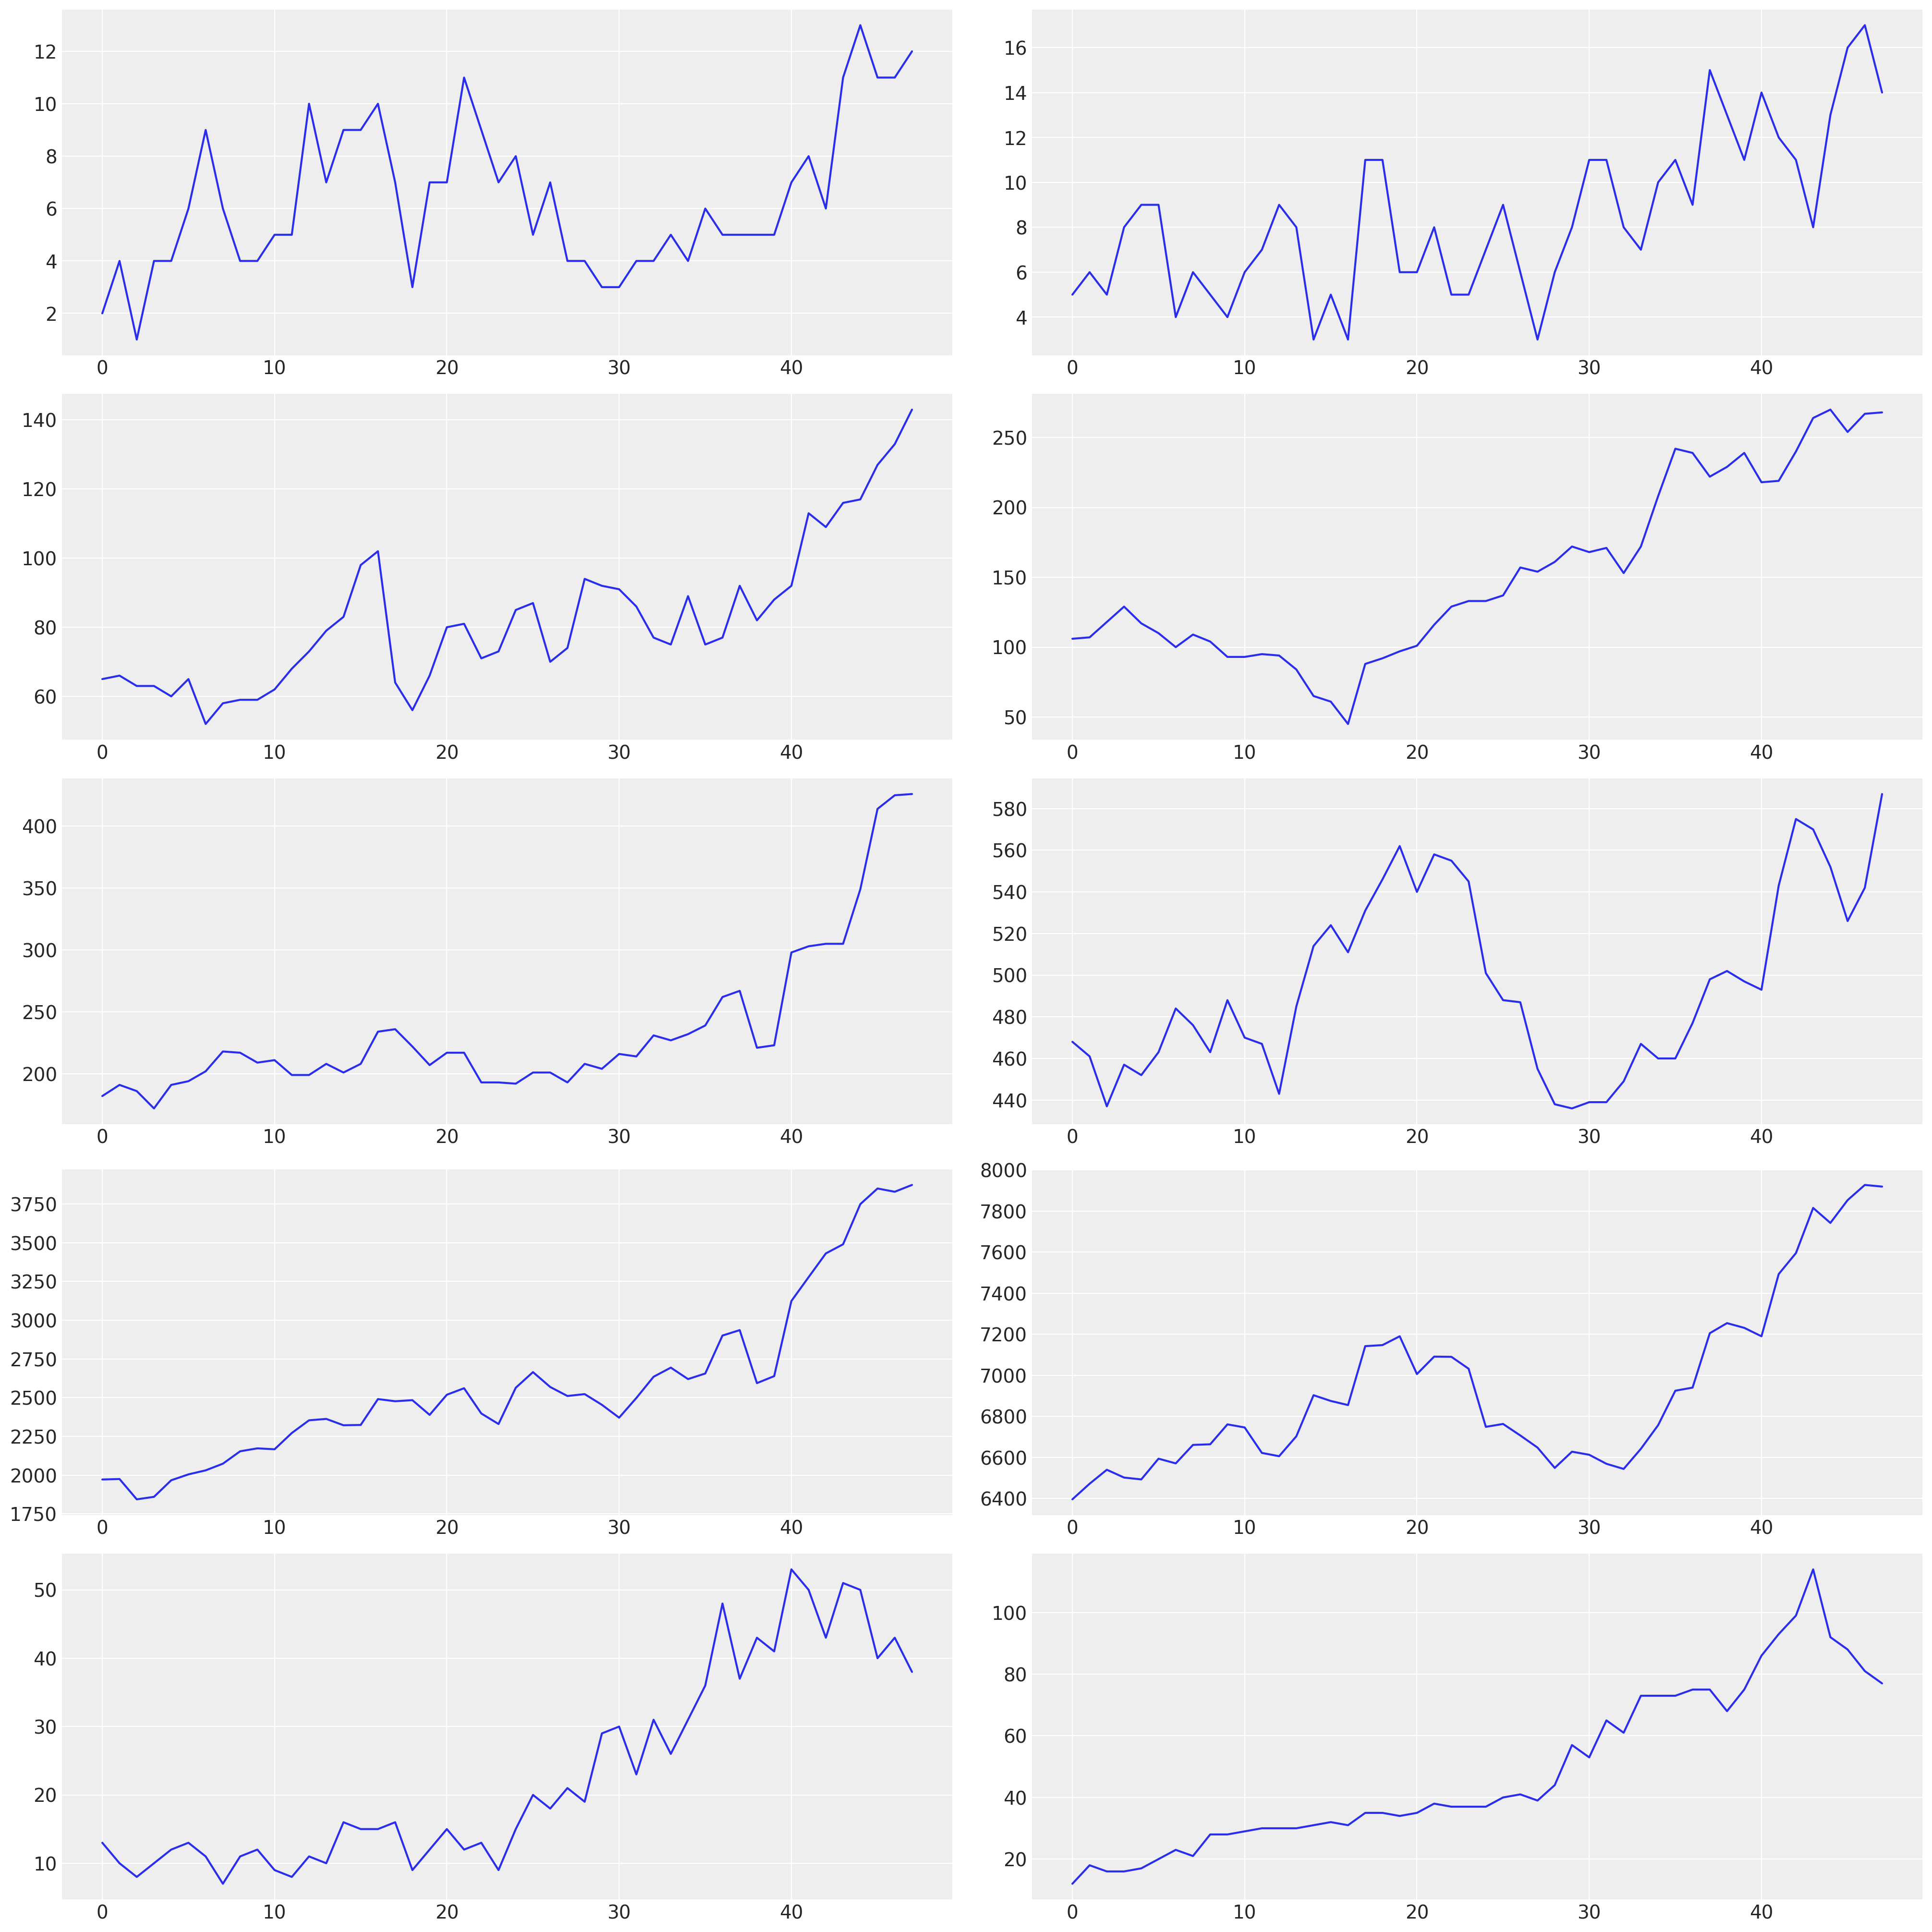

In [113]:
fig, ax = plt.subplots(5, 2, figsize=(20, 20))

ax = ax.ravel()

for i in range(10):
    ax[i].plot(groups['predict']['data'][:,i])

We are adding normaly distributed noise to the data and for every 5 points in 100 we are creating an outlier. To define the outlier we use a uniform distribution from 1.5 to 2 times the median (< or > U(1.5,2) $\cdot$ median).

$$\begin{align}
I_{ij} &= \text{Bern}(0.5) \\
N_{ij} &= \mathcal{N}(0, \frac{\sigma_{Z_j}}{2}) \\
O_{ij} &= \text{Bern}(0.05) \\
M_{ij} &= \text{U}(1.5, 2) \\
Y_{ij} &= \max{(Z_{ij} + N_{ij} + O_{ij} \cdot median(Z_j) \cdot (M_{ij} \cdot I_{ij} - M_{ij} \cdot (1-I_{ij}), \textbf{0})}
\end{align}$$

In [114]:
μ_noise = 0
σ_noise = np.std(groups['predict']['data'], axis=0)/2

I = stats.bernoulli.rvs(0.5, size=(groups['predict']['n'],groups['predict']['s']))
O = stats.bernoulli.rvs(0.05, size=(groups['predict']['n'], groups['predict']['s']))
N = np.random.normal(μ_noise, σ_noise, size=(groups['predict']['n'], groups['predict']['s']))

data_w_noise = (np.maximum(np.round(groups['predict']['data'] + N + O 
                * np.median(groups['predict']['data'][:,0]) * (1.5 * I - 1.5*(1-I)),0), np.zeros((groups['predict']['n'], groups['predict']['s']))))

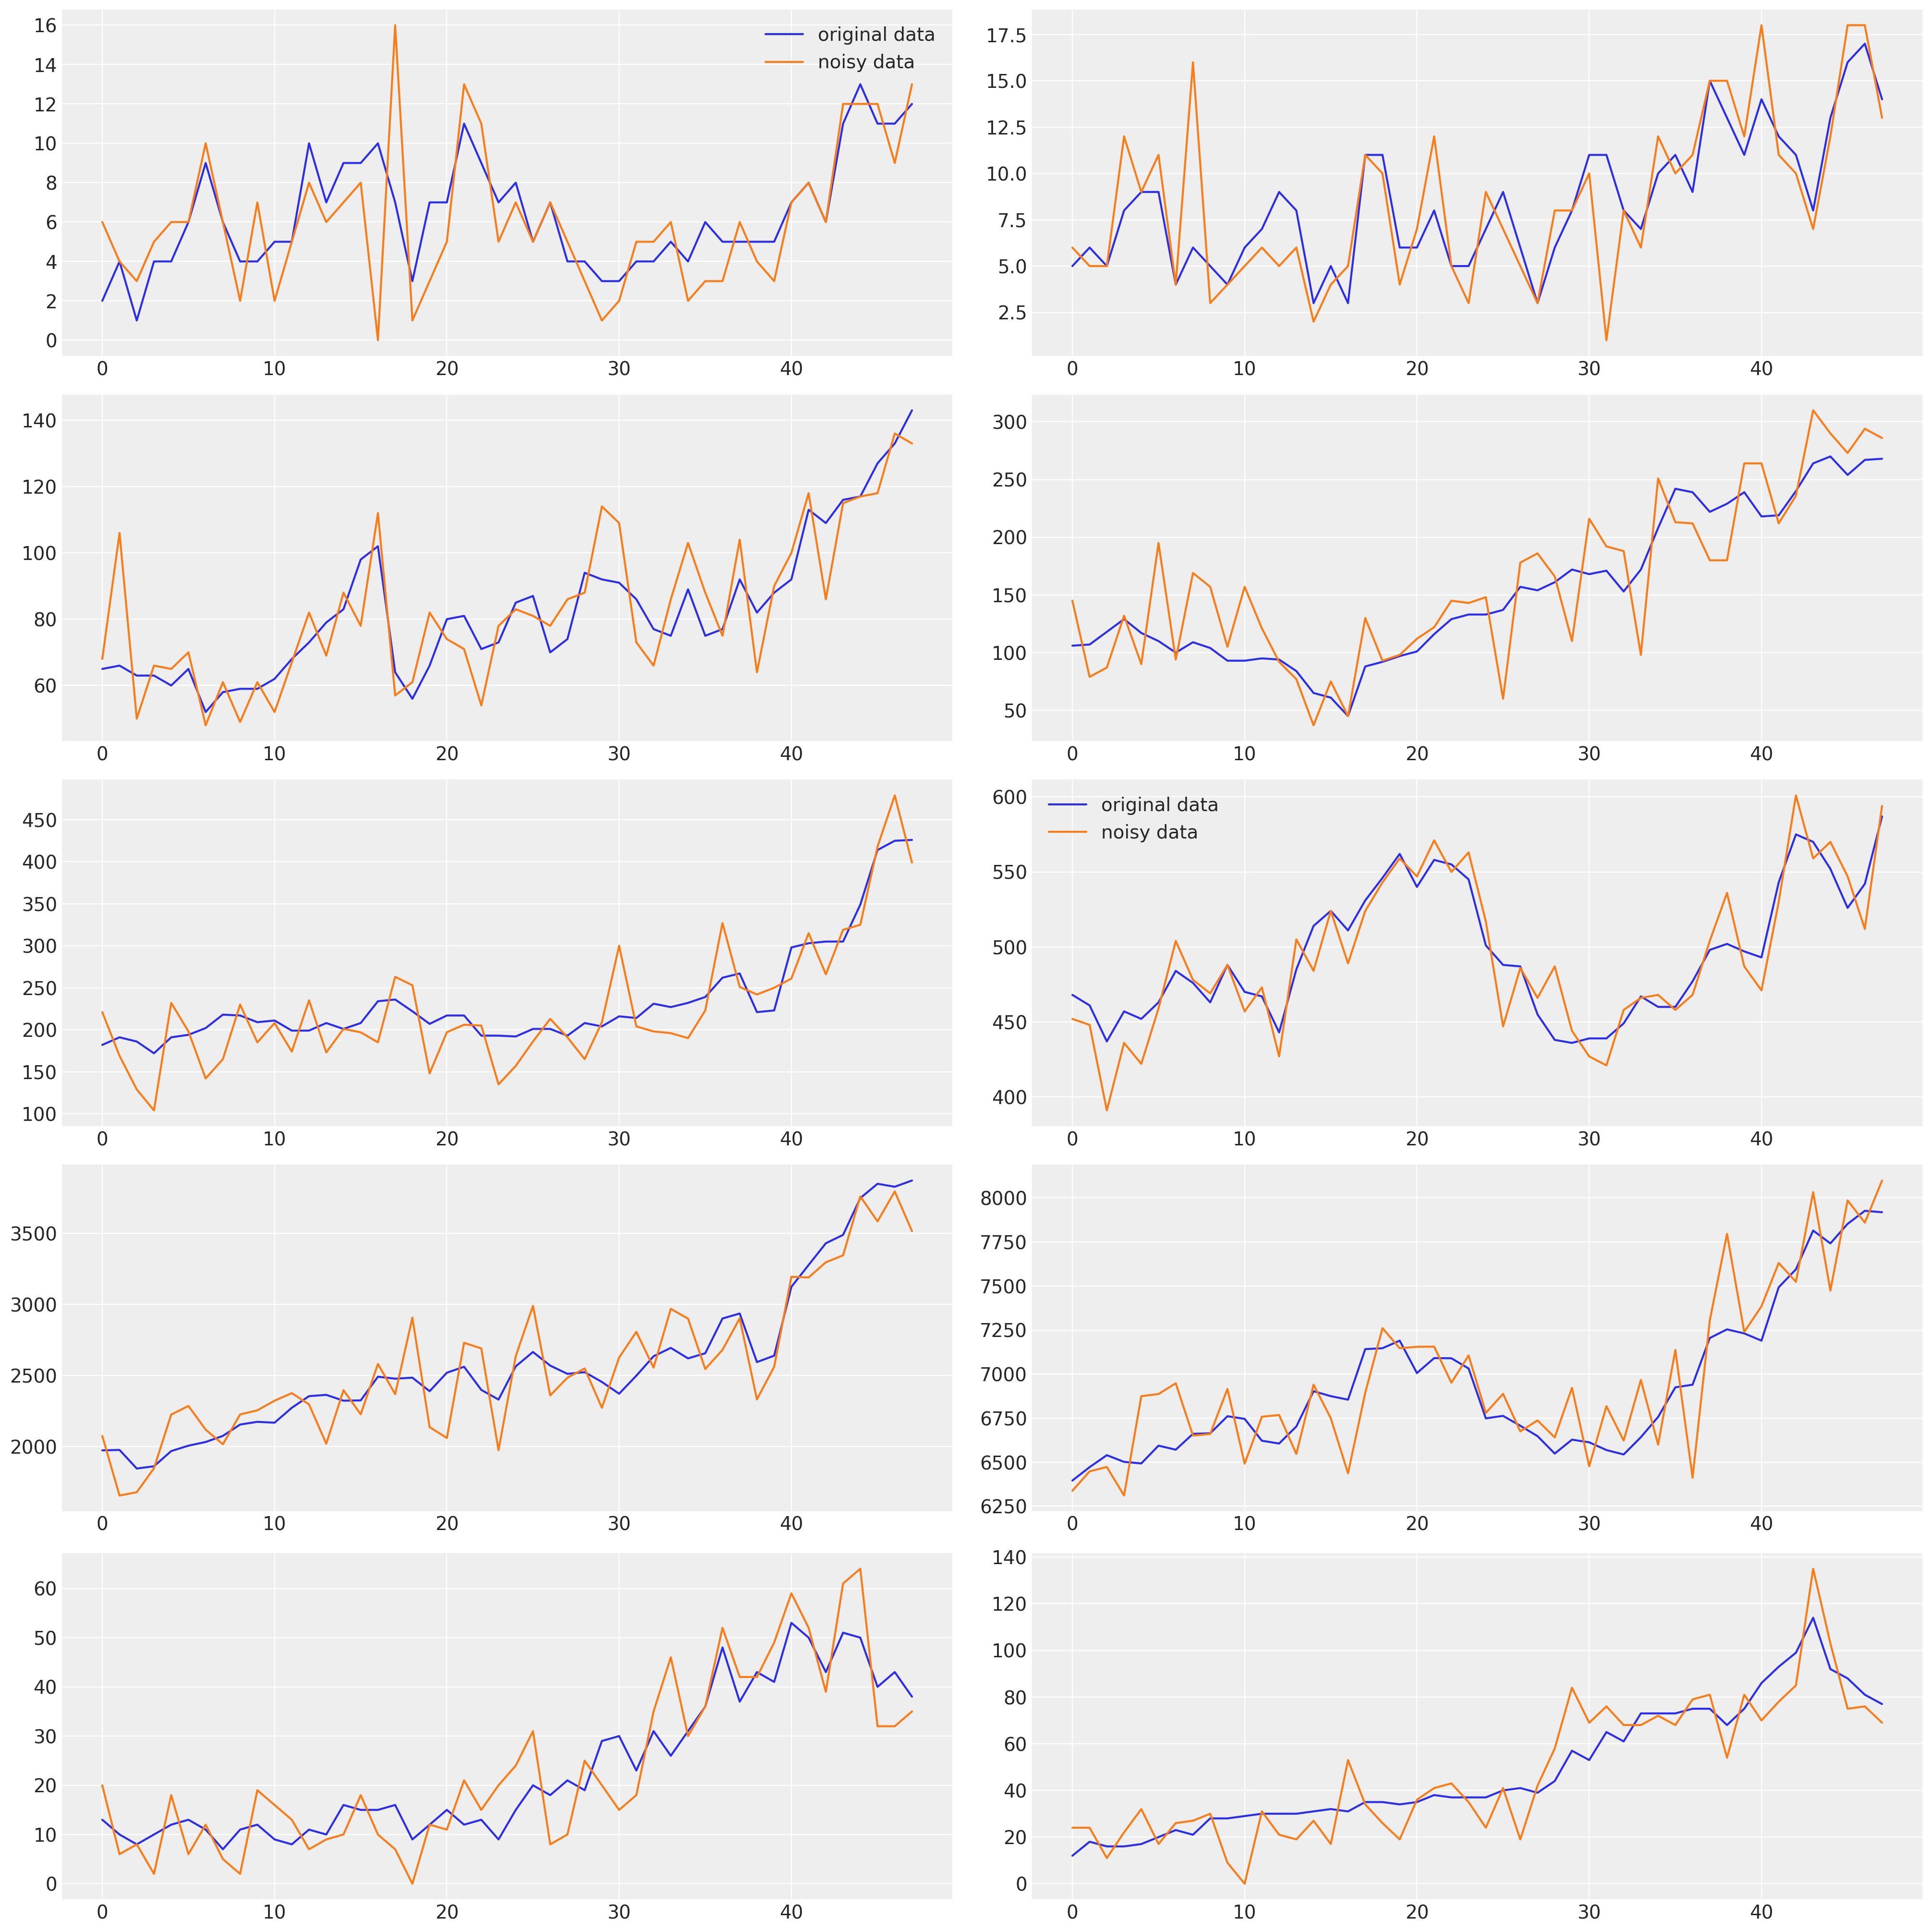

In [115]:
fig, ax = plt.subplots(5, 2, figsize=(20, 20))

ax = ax.ravel()

for i in range(10):
    ax[i].plot(np.arange(groups['predict']['n']),groups['predict']['data'][:,i], label='original data')
    ax[i].plot(np.arange(groups['predict']['n']), data_w_noise[:,i], label='noisy data')
    if i%5==0:
        ax[i].legend()

In [116]:
prison = pd.read_csv('../data/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['Date'] = prison['t'].astype('datetime64[ns]')
prison = prison.drop('t', axis=1)
prison = prison.set_index('Date')
prison.columns= ['State', 'Gender', 'Legal', 'Count']

In [117]:
prison['data_w_noise'] = data_w_noise.T.reshape((-1,))

In [118]:
prison = prison.drop(columns=['Count'])
prison = prison.rename(columns={'data_w_noise': 'Count'})

In [95]:
prison.to_csv('../data/prison_task2_to_r.csv')

# Tourism task2

In [135]:
data = pd.read_csv('../data/TourismData_v3.csv')
data['Year'] = data['Year'].fillna(method='ffill')

d = dict((v,k) for k,v in enumerate(calendar.month_name))
data.Month = data.Month.map(d)
data = data.assign(t=pd.to_datetime(data[['Year', 'Month']].assign(day=1))).set_index('t')
data = data.drop(['Year', 'Month'], axis=1)
data = data.round()

groups_input = {
    'state': [0,1],
    'zone': [0,2],
    'region': [0,3],
    'purpose': [3,6]
}

In [136]:
groups = generate_groups_data_flat(y = data, 
                               groups_input = groups_input, 
                               seasonality=12, 
                               h=24)

Number of groups: 4
	state: 7
	zone: 27
	region: 76
	purpose: 4
Total number of series: 304
Number of points per series for train: 204
Total number of points: 228
Seasonality: 12
Forecast horizon: 24


In [137]:
#groups = generate_groups_data_matrix(groups)

groups['predict']['data'] = groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T

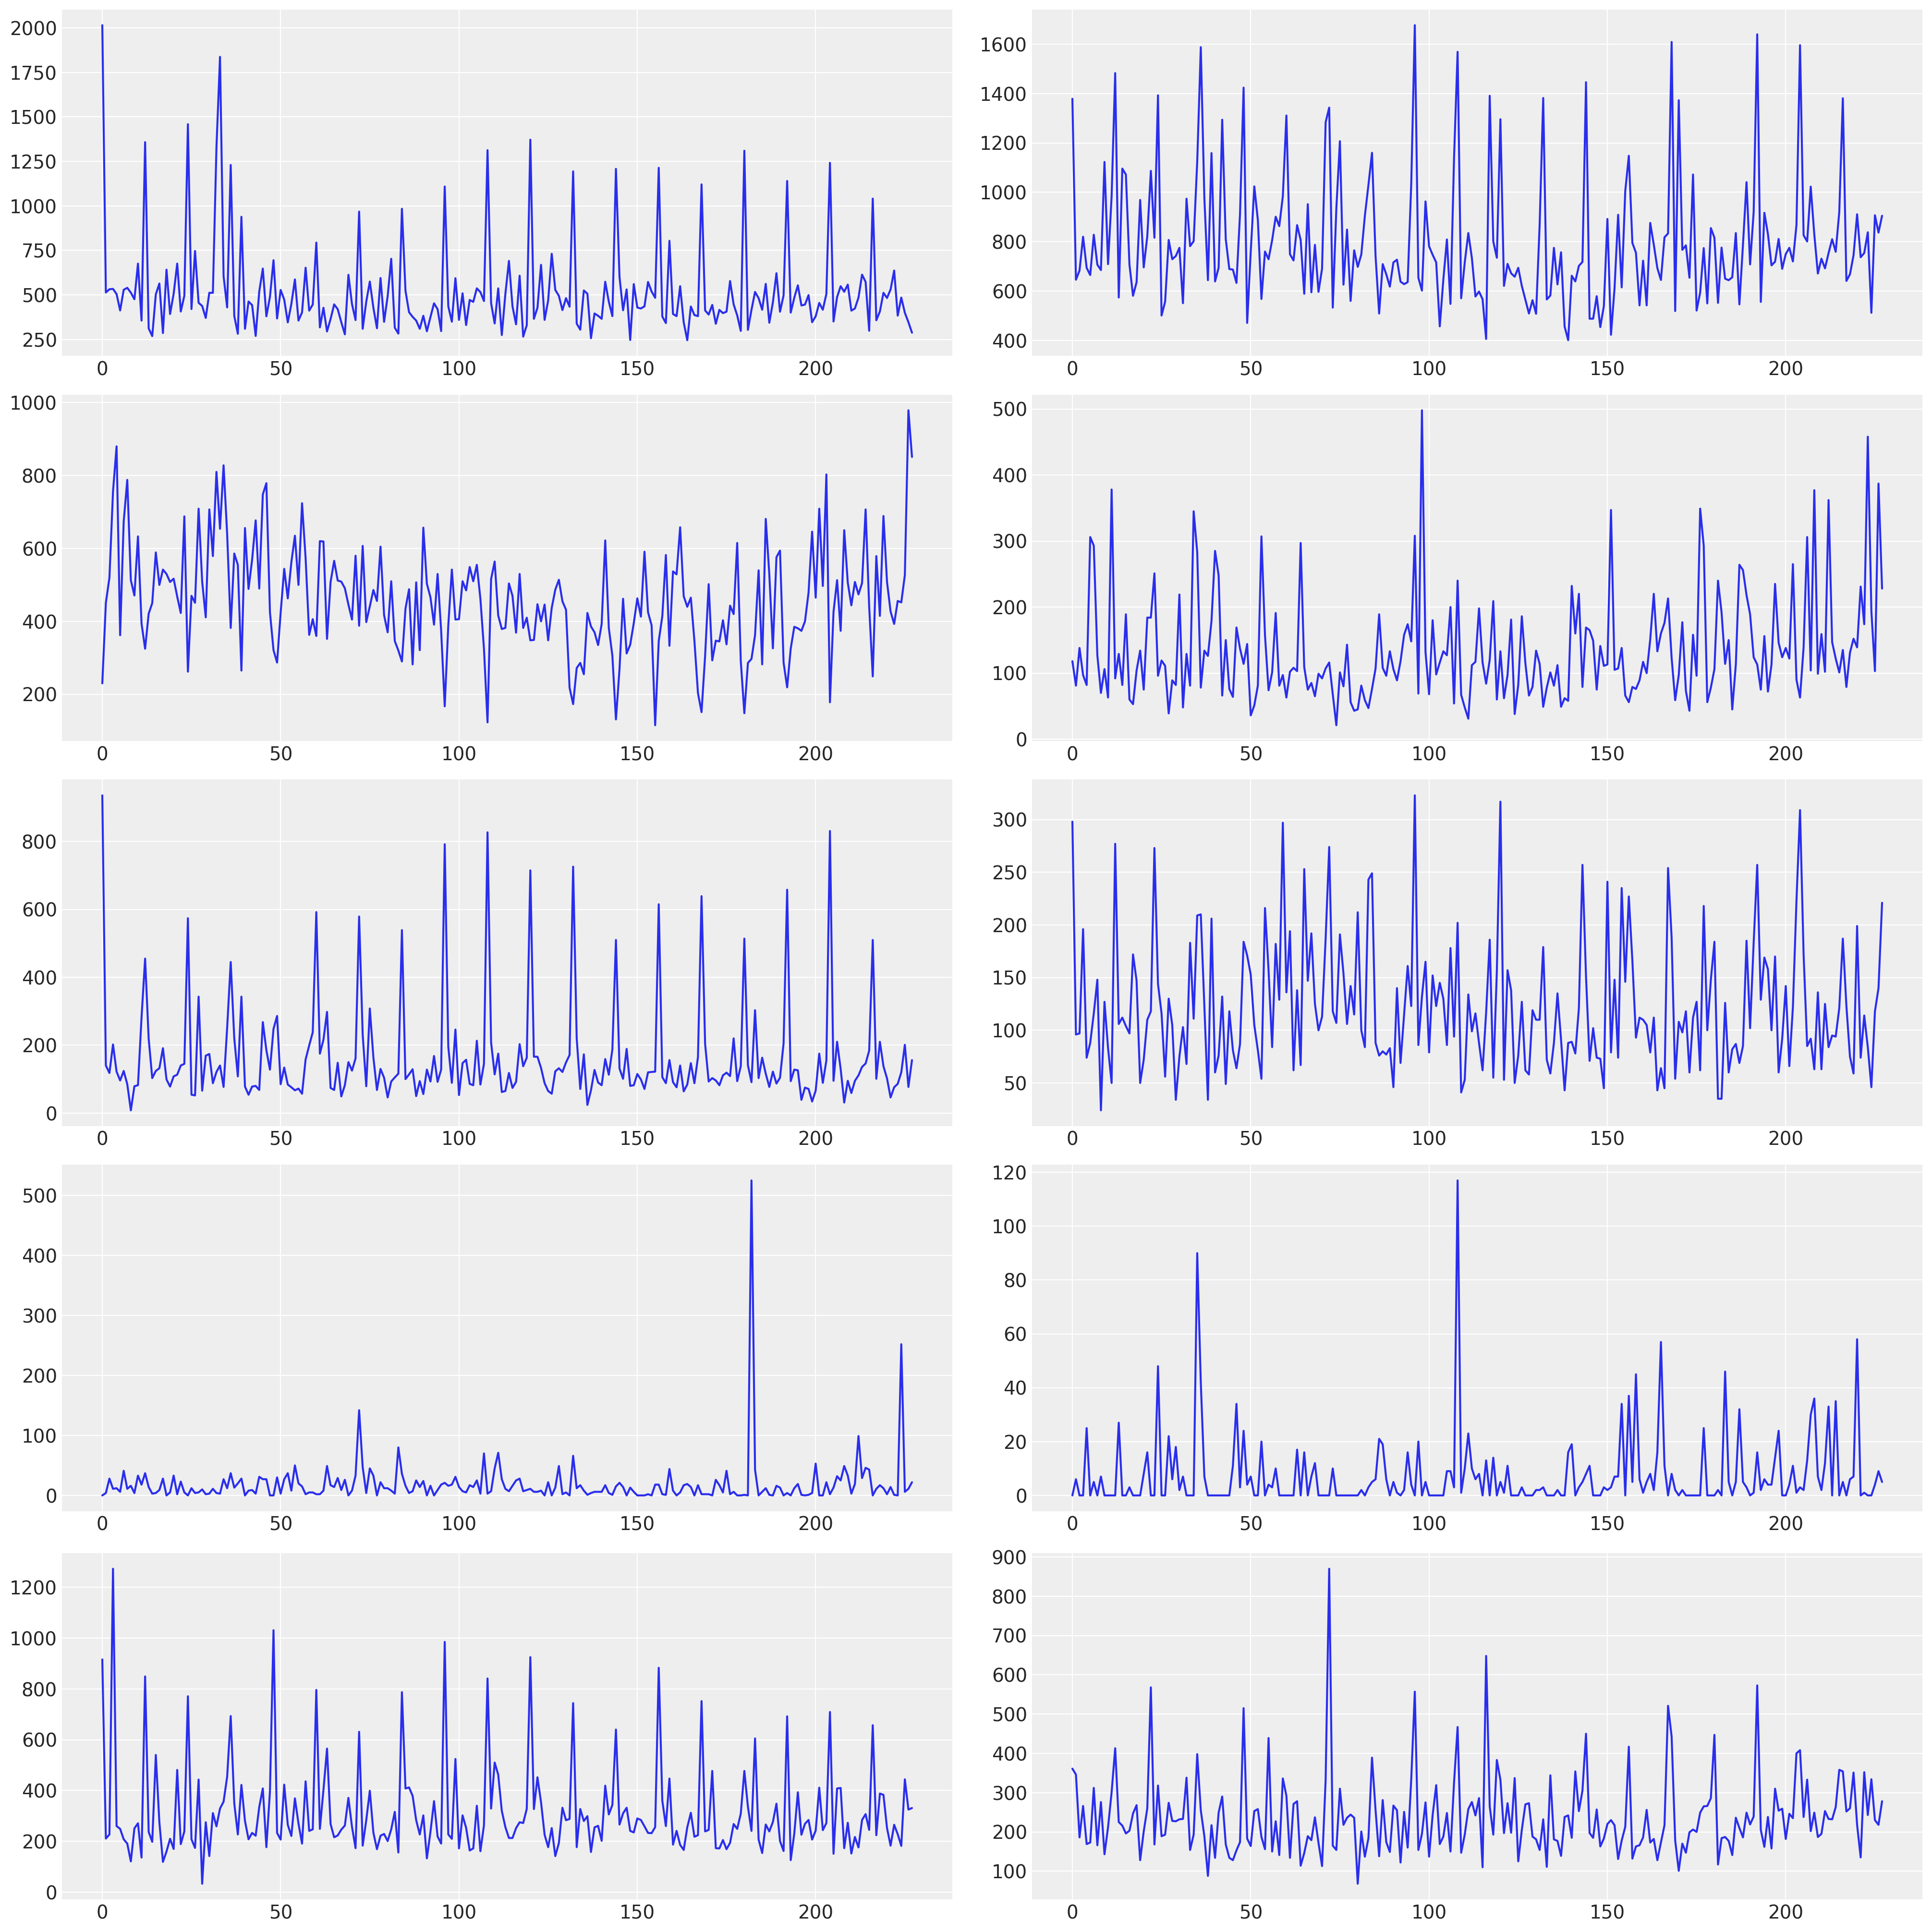

In [138]:
fig, ax = plt.subplots(5, 2, figsize=(20, 20))

ax = ax.ravel()

for i in range(10):
    ax[i].plot(groups['predict']['data'][:,i])

We are adding normaly distributed noise to the data and for every 5 points in 100 we are creating an outlier. To define the outlier we use a uniform distribution from 1.5 to 2 times the median (< or > U(1.5,2) $\cdot$ median).

$$\begin{align}
&I_{ij} = \text{Bern}(0.5) \\
&N_{ij} = \mathcal{N}(0, \frac{\sigma_{Z_j}}{2}) \\
&O_{ij} = \text{Bern}(0.05) \\
&M_{ij} = \text{U}(1.5, 2) \\
&Z_{ij} + N_{ij} + O_{ij} \cdot median(Z_j) \cdot (M_{ij} \cdot I_{ij} - M_{ij} \cdot (1-I_{ij}))\end{align}$$

In [139]:
μ_noise = 0
σ_noise = np.std(groups['predict']['data'], axis=0)/2

I = stats.bernoulli.rvs(0.5, size=(groups['predict']['n'],groups['predict']['s']))
O = stats.bernoulli.rvs(0.05, size=(groups['predict']['n'], groups['predict']['s']))
N = np.random.normal(μ_noise, σ_noise.reshape(1,-1), size=(groups['predict']['n'], groups['predict']['s']))

data_w_noise = ((groups['predict']['data'] + N + O 
                * np.median(groups['predict']['data']) * (1.5 * I - 1.5*(1-I))).astype('int32'))

data_w_noise[data_w_noise < 0] = int(0)

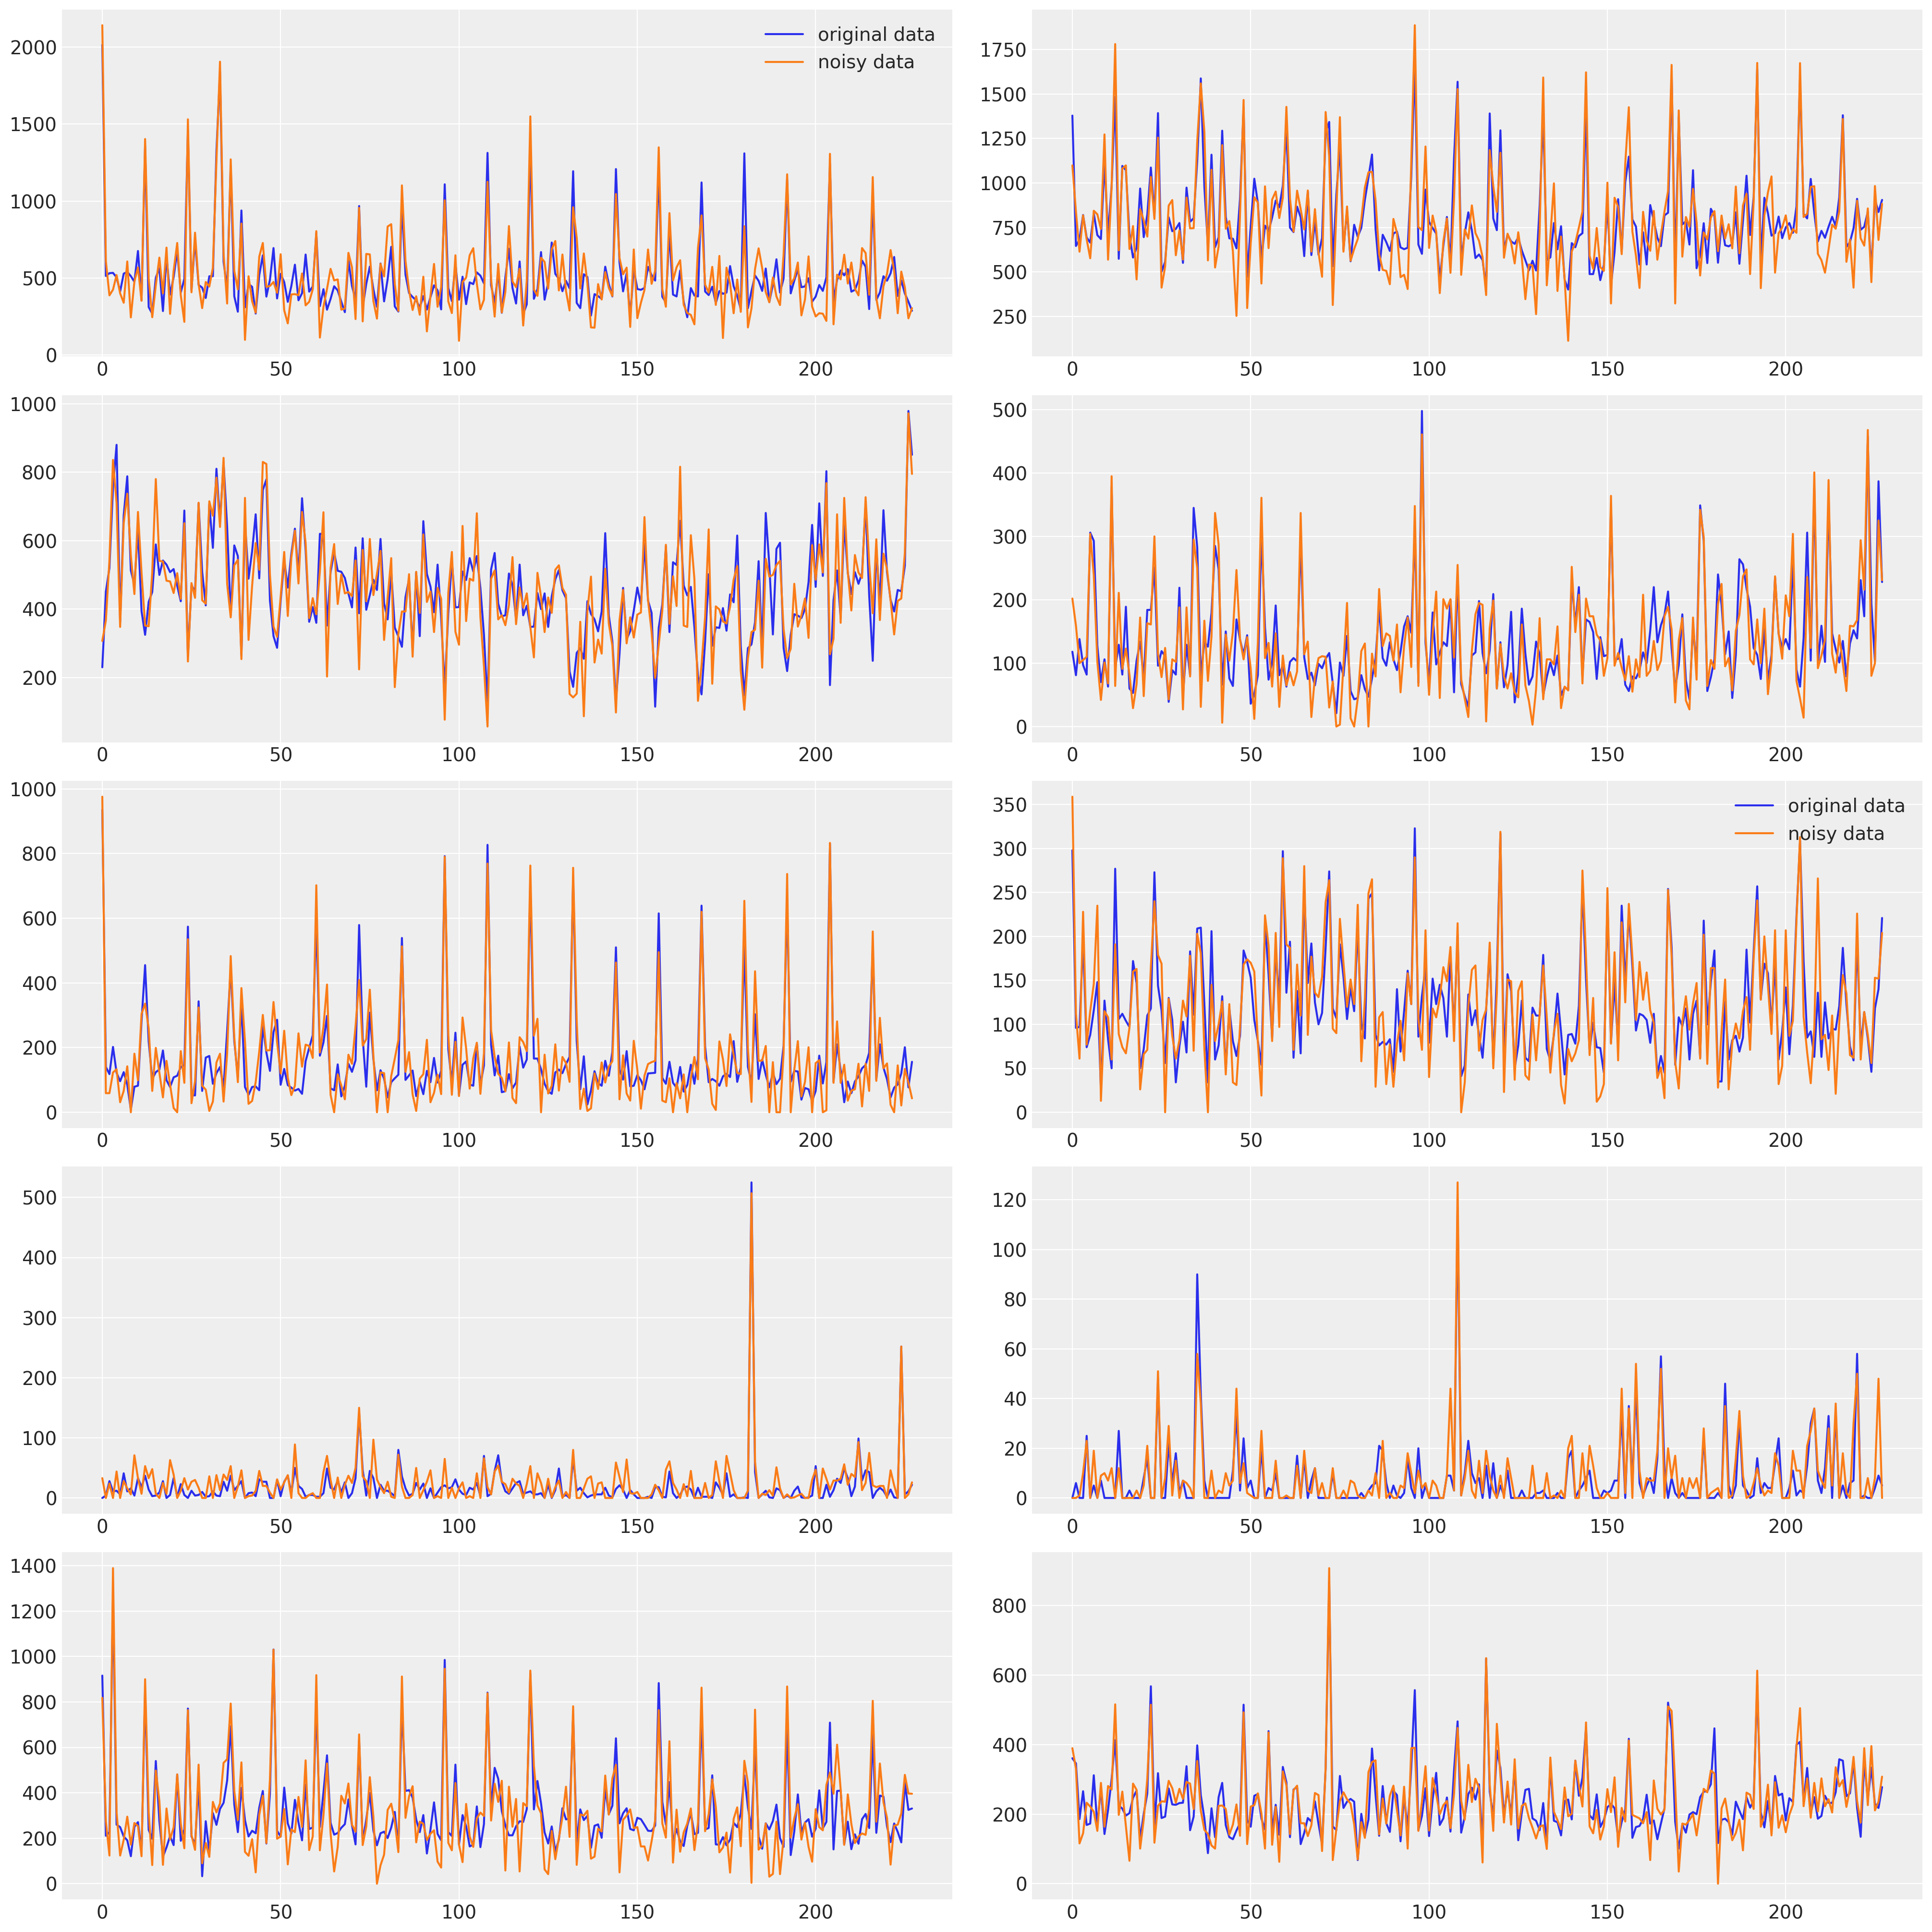

In [140]:
fig, ax = plt.subplots(5, 2, figsize=(20, 20))

ax = ax.ravel()

for i in range(10):
    ax[i].plot(np.arange(groups['predict']['n']),groups['predict']['data'][:,i], label='original data')
    ax[i].plot(np.arange(groups['predict']['n']), data_w_noise[:,i], label='noisy data')
    if i%5==0:
        ax[i].legend()

In [141]:
n_train = groups['train']['n']
s = groups['train']['s']
n = groups['predict']['n']
data_w_noise_train = data_w_noise[:n_train,:].T.reshape(-1)
groups['train']['data'] = data_w_noise_train
groups['predict']['data'] = data_w_noise

In [142]:
groups['predict']['data'] = groups['predict']['data'].T.reshape(-1)

In [143]:
tourism = prepare_data_to_R(groups, data.index)

In [146]:
tourism.to_csv('../data/tourism_task2_to_r.csv')